In [1]:
import timeit
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
from src import camvid
from src import segnet
from src.tiramisu import tiramisu
from src.tiramisu import aleatoric_tiramisu
from src.tiramisu import epi_approx_tiramisu
from src import wrappers
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# the size to crop images to
crop_size = (352, 480)

# Data

In [3]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(),
    target_size=(360, 480),
    crop_size=crop_size,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


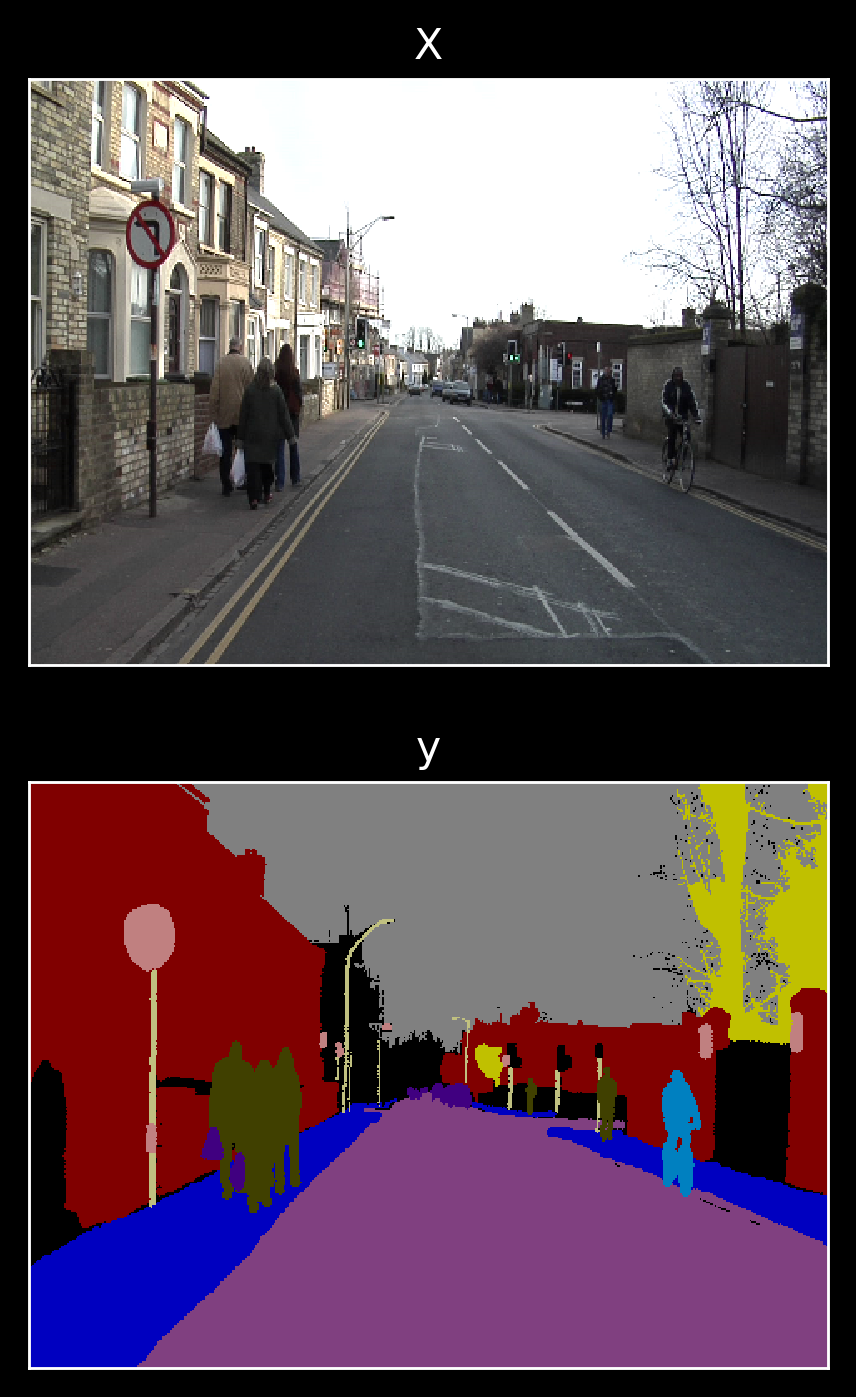

In [4]:
# get the next X, y training tuple
X, y = next(generators['test'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

# Build Models

In [5]:
def new_keras_session(build_model):
    """A decorator to clear the Keras session and build a model."""
    def _new_keras_session(*args, **kwargs):
        # clear the Keras session
        K.clear_session()
        # call the method to build a Keras model
        return build_model(*args, **kwargs)
    # reset the name of the method to the original name
    _new_keras_session.__name__ = build_model.__name__

    return _new_keras_session

In [6]:
@new_keras_session
def build_segnet():
    """Return a trained SegNet model."""
    return segnet.segnet((*crop_size, 3), camvid11.n, camvid11.class_weights)

In [7]:
@new_keras_session
def build_baysiean_segnet():
    """Return a trained Bayesian SegNet model."""
    model = segnet.segnet((*crop_size, 3), camvid11.n, camvid11.class_weights, dropout_rate=0.5)
    return wrappers.MonteCarlo(model, 40)

In [8]:
@new_keras_session
def build_tiramisu_56():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu((*crop_size, 3), camvid11.n, camvid11.class_mask,
        growth_rate=12,
        layer_sizes=[4, 4, 4, 4, 4],
        bottleneck_size=4,
    )

In [9]:
@new_keras_session
def build_tiramisu_67():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu((*crop_size, 3), camvid11.n, camvid11.class_mask,
        growth_rate=16,
        layer_sizes=[5, 5, 5, 5, 5],
        bottleneck_size=5,
    )

In [10]:
@new_keras_session
def build_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    return tiramisu.tiramisu((*crop_size, 3), camvid11.n, camvid11.class_mask)

In [11]:
@new_keras_session
def build_aleatoric_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    return aleatoric_tiramisu.aleatoric_tiramisu((*crop_size, 3), camvid11.n, camvid11.class_mask)

In [12]:
@new_keras_session
def build_epistemic_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    model = tiramisu.tiramisu((*crop_size, 3), camvid11.n, camvid11.class_mask, mc_dropout=True)
    return wrappers.MonteCarlo(model, 40)

In [13]:
@new_keras_session
def build_epistemic_approx_tiramisu_103():
    """Return a trained Tiramisu (103 layers) model."""
    return epi_approx_tiramisu.epi_approx_tiramisu((*crop_size, 3), camvid11.n, camvid11.class_mask)

# Time Tests

In [14]:
def time_test(model, repeat: int=7) -> pd.Series:
    """
    Run a prediction time test for the given model.

    Args:
        repeat: the number of trials to generate mean and std time

    Returns:
        a series with the:
        - mean of the repeat trials
        - standard deviation of the repeat trials

    """
    # run time trials for the number of repetitions + 1
    times = timeit.repeat(lambda: model.predict(X), repeat=repeat + 1, number=1)
    # throw out the first time that usually is anomalous
    times = pd.Series(times[1:])
    # return a series with the data
    return pd.Series([times.mean(), times.std()], index=['mean', 'std'])

In [15]:
# generate a dataframe of results for each model in ms
results = pd.DataFrame({
    'SegNet': time_test(build_segnet()),
    'Bayesian-SegNet': time_test(build_baysiean_segnet()),
    'Tiramisu-56': time_test(build_tiramisu_56()),
#     'Tiramisu-67': time_test(build_tiramisu_67()),
    'Tiramisu-103': time_test(build_tiramisu_103()),
#     'Tiramisu-103 (Aleatoric)': time_test(build_aleatoric_tiramisu_103()),
    'Tiramisu-103 (Epistemic)': time_test(build_epistemic_tiramisu_103()),
#     'Tiramisu-103 (Epistemic Approximation)': time_test(build_epistemic_approx_tiramisu_103()),
}).T.sort_values('mean').T * 1000

In [16]:
results.T

,mean,std
SegNet,53.534229,0.247221
Tiramisu-56,74.497636,0.295071
Tiramisu-103,119.404883,2.060801
Bayesian-SegNet,2772.625226,14.349562
Tiramisu-103 (Epistemic),5838.325263,16.431716


In [17]:
print(tabulate(results.T, tablefmt='pipe', headers=('Model', 'Mean (ms)', 'SD. (ms)')))

| Model                    |   Mean (ms) |   SD. (ms) |
|:-------------------------|------------:|-----------:|
| SegNet                   |     53.5342 |   0.247221 |
| Tiramisu-56              |     74.4976 |   0.295071 |
| Tiramisu-103             |    119.405  |   2.0608   |
| Bayesian-SegNet          |   2772.63   |  14.3496   |
| Tiramisu-103 (Epistemic) |   5838.33   |  16.4317   |


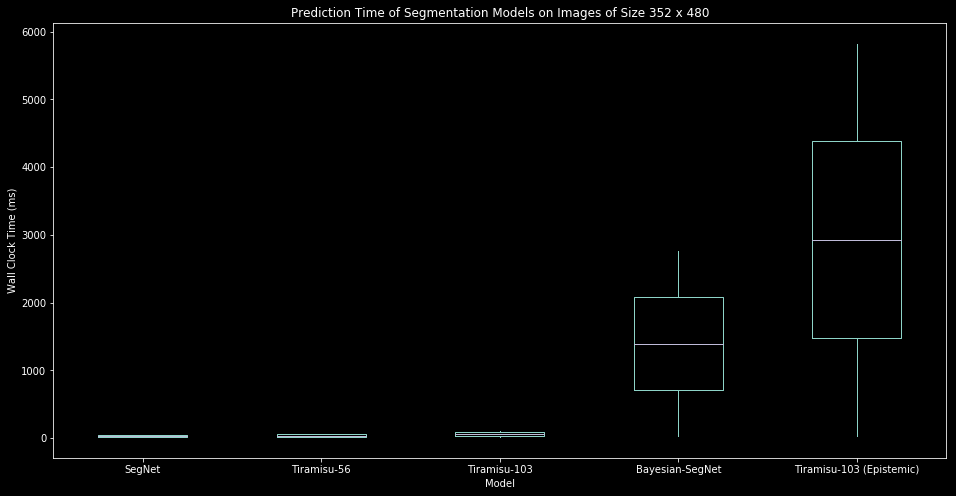

In [18]:
ax = results.plot.box(figsize=(16, 8))
ax.set_xlabel('Model')
ax.set_ylabel('Wall Clock Time (ms)')
ax.set_title('Prediction Time of Segmentation Models on Images of Size 352 x 480')
plt.savefig('img/inference-time.png', transparent=True, bbox_inches='tight')